# Week2 LAB: Regularization

### 강경훈

In [1]:
import numpy as np; np.set_printoptions(precision=3)
import pandas as pd; pd.set_option('display.precision',3)
import matplotlib.pyplot as plt

In [2]:
N = 50
v1, v2, v3, v4, v5, v6 = np.random.randn(N*6).reshape(6, -1)
X = pd.DataFrame(np.c_[v1, v2, v3]); X.columns = ['v1','v2','v3']
Y = (10 -5*v1 +4*v2 + 3*v4+ 7* v5 + 1*v1**2 + 0.2 * v2**2 + 0.5 * v1*v2 + 0.5* v6**3 + np.random.randn(N)*1.5)
Y = pd.DataFrame(Y)

### Train-Test Split

In [3]:
from sklearn.model_selection import train_test_split
X_train_sc, X_test_sc, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

X_train_sc.reset_index(drop=True, inplace=True)
X_test_sc.reset_index(drop=True, inplace=True)
Y_train.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)

### Feature Extraction

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

In [5]:
poly = PolynomialFeatures(degree=2)
Phi_train = poly.fit_transform(X_train_sc)
Phi_test = poly.fit_transform(X_test_sc)
print(Phi_train.shape)
print(Phi_test.shape)

(35, 10)
(15, 10)


### Simple Linear Regression

In [6]:
from sklearn.linear_model import LinearRegression

In [7]:
lin = LinearRegression()
lin.fit(Phi_train, Y_train)
print(lin.intercept_)
print(lin.coef_)

[9.016]
[[ 0.    -6.074  5.786 -1.406 -0.632 -2.167  2.01   0.467  1.22   1.625]]


### Ridge Regression

Ridge와 Lasso 모두 sklearn에서 사용하는 방법은 LinearRegression()과 똑같다. 함수를 객체로 불러오고, 람다 계수 정해주고, 그 다음 train set 피팅해서 학습하고 결과는 .coef_로 보고, .predict(테스트 셋) 해서 예측하고.

In [8]:
from sklearn.linear_model import Ridge
alphas=np.logspace(-6, 6, 500)

In [9]:
def Ridge_Reg(Phi_train, Y_train, Phi_test, Y_test, alphas, fig=False):
    
    ## How to Ridge?##
    #1. Call Ridge function as an object
    reg = Ridge()
    
    coefs = []
    train_MSE = []
    test_MSE = []
    
    for a in alphas:
        #2. Choose your lambda (Regularization coefficient)
        reg.set_params(alpha=a)
        
        #3. Fit your model
        reg.fit(Phi_train, Y_train)
        
        #4 view result with reg.coef_, reg.predict, ...
        coefs.append(reg.coef_)
    
        train_pred = reg.predict(Phi_train)
        train_MSE.append(mean_squared_error(Y_train, train_pred))
    
        test_pred = reg.predict(Phi_test)
        test_MSE.append(mean_squared_error(Y_test, test_pred))
   
    ## just for plotting purpose.. trivial ##
    #print(np.array(coefs).shape)
    
    if fig==True:
        fig = plt.figure(figsize=(14,6))

        ax1 = fig.add_subplot(121)
        labels = ['X%d'%i for i in range(Phi_train.shape[1])]
        for i in range(Phi_train.shape[1]):
            ax1.plot(alphas, np.array(coefs)[:,:,i], label=labels[i])
        ax1.set_xscale('log')
        ax1.axvline(x=alphas[np.argmin(test_MSE)], linestyle='--', color='grey')
        ax1.legend()

        ax2 = fig.add_subplot(122)
        ax2.plot(alphas, train_MSE, label='Train MSE')
        ax2.plot(alphas, test_MSE, label='Test MSE')
        ax2.set_xscale('log')
        ax2.axvline(x=alphas[np.argmin(test_MSE)], linestyle='--', color='grey')
        alpha = np.around(alphas[np.argmin(test_MSE)],3)
        ax2.text(alphas[np.argmin(test_MSE)], np.amin(test_MSE), 'alpha={0}'.format(alpha), size=15)
        ax2.legend()

        print("Weight:" ,coefs[np.argmin(test_MSE)])
        
    return {'coefs': coefs, 'train_MSE': train_MSE, 'test_MSE': test_MSE}

Weight: [[ 0.    -3.917  3.14  -1.046 -0.326 -1.01   1.381  0.411  0.338  1.134]]


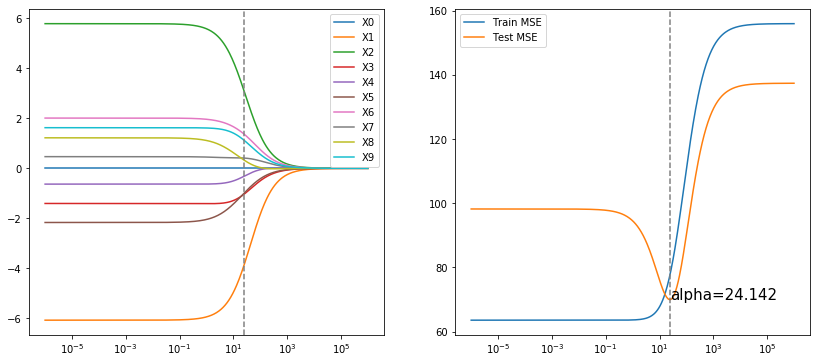

In [10]:
Ridge_output = Ridge_Reg(Phi_train, Y_train, Phi_test, Y_test, alphas, fig=True)

어 왜 intercept 포함해요? 굉장히 좋은 질문이다. Ridge와 Lasso를 할 때 intercept까지 peanalize할지 말지를 결정해야하는데, 흠... 상식적으로 생각해보자. 애초에 Regularization을 하는 이유는 feature는 많지만 데이터가 적어서 생기는 복잡한 모델의 과격한 행동(과민하게 에러까지 먹고 막)을 막기 위해서이다. 그렇다면 feature가 늘수록 intercept가 줄어드는게 맞나? 아니다. 애초에 intercept의 의미는, 우리가 모든 설명변수를 표준화했다면 __모든 설명변수의 값이 평균일 때의 기대되는 종속변수의 값__ 이다. 때문에 intercept는 패널티를 안 주는게 맞다. 밑에 코드에서 인터셉트를 굳이 뺀다고 안하고 Ridge를 돌리면 intercept는 알아서 빼고 나머지 항에 대해서만 정규화를 한다. 그리고 1로만 된 첫 행은 intercept와 겹치니까 그냥 계수가 쭉 0이 된다. https://www.coursera.org/lecture/ml-regression/how-to-handle-the-intercept-3KZiN

### Lasso Regression

In [11]:
from sklearn.linear_model import Lasso
alphas=np.logspace(-6, 6, 500)

In [12]:
def Lasso_Reg(Phi_train, Y_train, Phi_test, Y_test, alphas, fig=False):
    
    ## How to Lasso?##
    #1. Call Lasso function as an object
    reg = Lasso()
    
    coefs = []
    train_MSE = []
    test_MSE = []
    
    for a in alphas:
        #2. Choose your lambda (Regularization coefficient)
        reg.set_params(alpha=a)
        
        #3. Fit your model
        reg.fit(Phi_train, Y_train)
        
        #4 view result with reg.coef_, reg.predict, ...
        coefs.append(reg.coef_)
    
        train_pred = reg.predict(Phi_train)
        train_MSE.append(mean_squared_error(Y_train, train_pred))
    
        test_pred = reg.predict(Phi_test)
        test_MSE.append(mean_squared_error(Y_test, test_pred))
    
    ## just for plotting purpose.. trivial ##
    #print(np.array(coefs).shape)
    if fig==True:
        fig = plt.figure(figsize=(14,6))

        ax1 = fig.add_subplot(121)
        labels = ['X%d'%i for i in range(Phi_train.shape[1])]
        for i in range(Phi_train.shape[1]):
            ax1.plot(alphas, np.array(coefs)[:,i], label=labels[i])
        ax1.set_xscale('log')
        ax1.axvline(x=alphas[np.argmin(test_MSE)], linestyle='--', color='grey')
        ax1.legend()

        ax2 = fig.add_subplot(122)
        ax2.plot(alphas, train_MSE, label='Train MSE')
        ax2.plot(alphas, test_MSE, label='Test MSE')
        ax2.set_xscale('log')
        ax2.axvline(x=alphas[np.argmin(test_MSE)], linestyle='--', color='grey')
        alpha = np.around(alphas[np.argmin(test_MSE)],3)
        ax2.text(alphas[np.argmin(test_MSE)], np.amin(test_MSE), 'alpha={0}'.format(alpha), size=15)
        ax2.legend()

        print("Weight:" ,coefs[np.argmin(test_MSE)])
        
    return {'coefs': coefs, 'train_MSE': train_MSE, 'test_MSE': test_MSE}

Weight: [ 0.    -5.556  3.681 -0.    -0.    -0.538  0.39   0.    -0.     0.414]


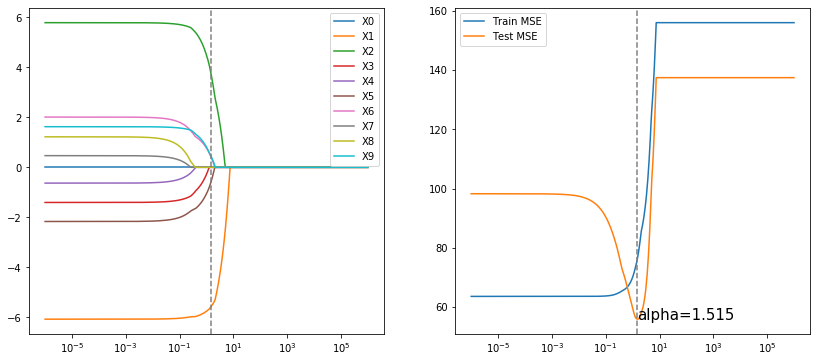

In [13]:
Lasso_output = Lasso_Reg(Phi_train, Y_train, Phi_test, Y_test, alphas, fig=True)

Ridge가 완만하게 계수를 조진다면, Lasso는 화끈하게 쳐내버리는 것을 볼 수 있다.

### k-fold CV for $\lambda$

sklearn에서 kfold 함수는 데이터를 k개의 train-test split으로 나누는 __index를 뱉는다__. 즉 인덱스만 뱉어주므로 직접 그 인덱스가지고 데이터에서 뽑아내는 것은 직접 해야하는 것. 때문에 미리 데이터를 준비하고, Ridge든 뭐든 자체적으로 만든 함수도 준비해서, for 구문 안에서 끝나도록 해보자.

In [14]:
import numpy as np
from sklearn.model_selection import KFold

kcv = KFold(n_splits=5, shuffle=True)

kcvMSE_Ridge = np.zeros((kcv.get_n_splits(), alphas.size))
kcvMSE_Lasso = np.zeros((kcv.get_n_splits(), alphas.size))

i = 0
for train_index, test_index in kcv.split(Phi_train, Y_train):
    print("TRAIN:", train_index, "TEST:", test_index)
    CV_Phi_train, CV_Phi_test = Phi_train[train_index,:], Phi_train[test_index,:]
    CV_Y_train, CV_Y_test = Y_train.iloc[train_index,:], Y_train.iloc[test_index,:]
    
    Ridge_output = Ridge_Reg(CV_Phi_train, CV_Y_train, CV_Phi_test, CV_Y_test, alphas, fig=False)
    kcvMSE_Ridge[i, :] = Ridge_output['test_MSE']
    
    Lasso_output = Lasso_Reg(CV_Phi_train, CV_Y_train, CV_Phi_test, CV_Y_test, alphas, fig=False)
    kcvMSE_Lasso[i, :] = Lasso_output['test_MSE']
    i += 1

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 12 13 14 16 18 21 22 23 24 25 26 27 28 29
 30 32 33 34] TEST: [10 11 15 17 19 20 31]
TRAIN: [ 3  4  5  6  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24 25 27 28 30
 31 32 33 34] TEST: [ 0  1  2  7 13 26 29]
TRAIN: [ 0  1  2  3  4  5  7  9 10 11 13 14 15 16 17 18 19 20 22 23 25 26 27 28
 29 31 32 33] TEST: [ 6  8 12 21 24 30 34]
TRAIN: [ 0  1  2  4  6  7  8  9 10 11 12 13 14 15 17 19 20 21 22 23 24 26 29 30
 31 32 33 34] TEST: [ 3  5 16 18 25 27 28]
TRAIN: [ 0  1  2  3  5  6  7  8 10 11 12 13 15 16 17 18 19 20 21 24 25 26 27 28
 29 30 31 34] TEST: [ 4  9 14 22 23 32 33]


Weight: [[ 0.    -4.621  3.317 -0.762 -0.191 -1.263  1.511  0.639  1.359  0.809]]


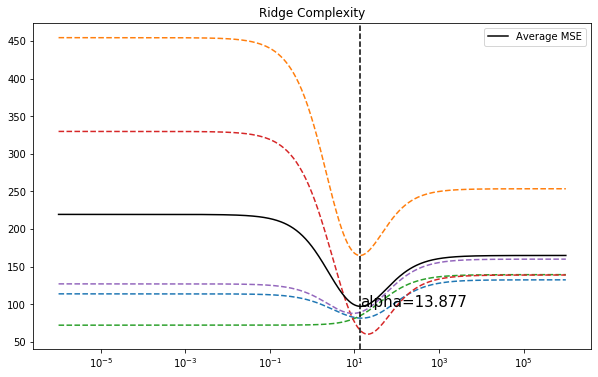

In [15]:
fig, ax= plt.subplots(figsize=(10,6))
meanMSE = np.apply_along_axis(np.mean, 1, kcvMSE_Ridge.T)
ax.plot(alphas, kcvMSE_Ridge.T, linestyle='--')
ax.plot(alphas, meanMSE, color='black', label='Average MSE')
ax.set_xscale('log')
ax.axvline(x=alphas[np.argmin(meanMSE)], linestyle='--', color='black')
alpha = np.around(alphas[np.argmin(meanMSE)],3)
ax.text(alphas[np.argmin(meanMSE)], np.amin(meanMSE), 'alpha={0}'.format(alpha), size=15)
ax.set_title('Ridge Complexity')
ax.legend()

coefs = Ridge_output['coefs']
print("Weight:" ,coefs[np.argmin(meanMSE)])

Weight: [ 0.    -5.98   2.722 -0.     0.    -0.078  0.056  0.     0.     0.   ]


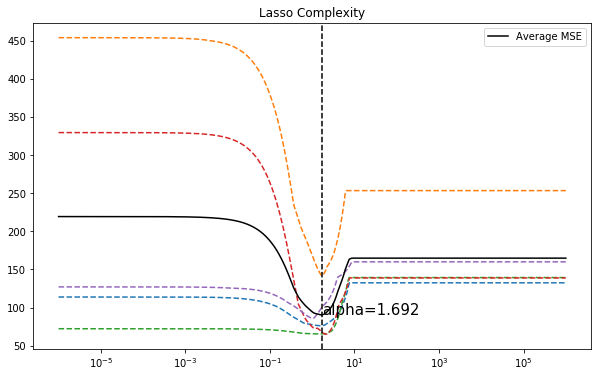

In [16]:
fig, ax= plt.subplots(figsize=(10,6))
meanMSE = np.apply_along_axis(np.mean, 1, kcvMSE_Lasso.T)
ax.plot(alphas, kcvMSE_Lasso.T, linestyle='--')
ax.plot(alphas, meanMSE, color='black', label='Average MSE')
ax.set_xscale('log')
ax.axvline(x=alphas[np.argmin(meanMSE)], linestyle='--', color='black')
alpha = np.around(alphas[np.argmin(meanMSE)],3)
ax.text(alphas[np.argmin(meanMSE)], np.amin(meanMSE), 'alpha={0}'.format(alpha), size=15)
ax.set_title('Lasso Complexity')
ax.legend()

coefs = Lasso_output['coefs']
print("Weight:" ,coefs[np.argmin(meanMSE)])